In [1]:
# Dependencies
import pandas as pd
import random
import numpy as np
import requests
import json
from citipy import citipy
import matplotlib.pyplot as plt
import time

# Google developer API key
from config import api_key

In [2]:
# generate a list of 500 random latitudes using the random.uniform(-180,180) function in the same loop
near_lat = np.arange(0,1000).astype('float')
for i in range(0,len(near_lat)):
    near_lat[i] = random.uniform(-90,90)

In [3]:
# generate a list of 500 random longitudes using the random.uniform(-180,180) function in the same loop
near_lng = np.arange(0,1000).astype('float')
for i in range(0,len(near_lng)):
    near_lng[i] = random.uniform(-180,180)

In [4]:
# use the lists above to create a DataFrame
cities = pd.DataFrame(list(zip(near_lat,near_lng)), columns=["CitiPy Lat", "CitiPy Lng"])

In [5]:
# use citipy to locate the nearest city to the lat,lng coordinates above
city_names = []
country_codes = []
for x in range(0,len(near_lat)):
    city = citipy.nearest_city(near_lat[x],near_lng[x])
    city_name = city.city_name
    country = city.country_code
    city_names.append(city_name)
    country_codes.append(country)

In [6]:
# add the city names to the DataFrame
cities["City"] = city_names
cities["Country Code"] = country_codes
cities.head()

,CitiPy Lat,CitiPy Lng,City,Country Code
0,41.519656,-158.426732,kodiak,us
1,-74.221344,-3.148700,hermanus,za
2,77.011606,35.033527,vardo,no
3,67.968331,69.093372,aksarka,ru
4,-33.880074,-32.706502,arraial do cabo,br


In [7]:
# request weather data from openweathermap 
# (url = http://api.openweathermap.org/data/2.5/weather?q={city name},{country code}&APPID={your api key}
query_url = "http://api.openweathermap.org/data/2.5/weather?q="

units = 'imperial'

# collect data from api response in these lists
lat_city = []
lng_city = []
temp = []
humidity = []
cloudiness = []
wind_speed = []
response_data = []

# store names of cities with missing data in this list
missing_field = []

# counter for api allowance of 60 calls per minute
call_counter = 0

# this loops makes api requests from openweatherapi
for i in range(0,len(near_lat)):
    response = requests.get(f'{query_url}{city_names[i]},{country_codes[i]}&APPID={api_key}&units={units}')
    response_data.append(response)
    weather = response.json()
    call_counter +=1
    if call_counter == 59: # wait 60 seconds every 59 requests
        time.sleep(60)
        call_counter = 0
    try:
        lat_city.append(weather["coord"]["lat"])
        lng_city.append(weather["coord"]["lon"])
        temp.append(weather["main"]["temp"])
        humidity.append(weather["main"]["humidity"])
        cloudiness.append(weather["clouds"]["all"])
        wind_speed.append(weather["wind"]["speed"])
    except:
        missing_field.append(city_names[i])
        pass

In [8]:
# remove missing cities with missing fields from the DataFrame
cond = cities['City'].isin(missing_field)
weather_data = cities.drop(cities[cond].index)

In [9]:
# add columns for temperature, humidity, cloudiness, and wind speed to the DataFrame
weather_data["Latitude"] = lat_city
weather_data["Longitude"] = lng_city
weather_data["Temperature (F)"] = temp
weather_data["Humidity (%)"] = humidity
weather_data["Cloudiness (%)"] = cloudiness
weather_data["Wind Speed (mph)"] = wind_speed
weather_data.head()

,CitiPy Lat,CitiPy Lng,City,Country Code,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,41.519656,-158.426732,kodiak,us,57.79,-152.41,53.60,71,40,11.41
1,-74.221344,-3.148700,hermanus,za,-34.42,19.23,53.01,95,55,1.01
2,77.011606,35.033527,vardo,no,70.37,31.11,47.17,82,100,10.67
3,67.968331,69.093372,aksarka,ru,66.56,67.80,46.27,59,81,4.52
4,-33.880074,-32.706502,arraial do cabo,br,-22.97,-42.03,70.95,82,84,16.04


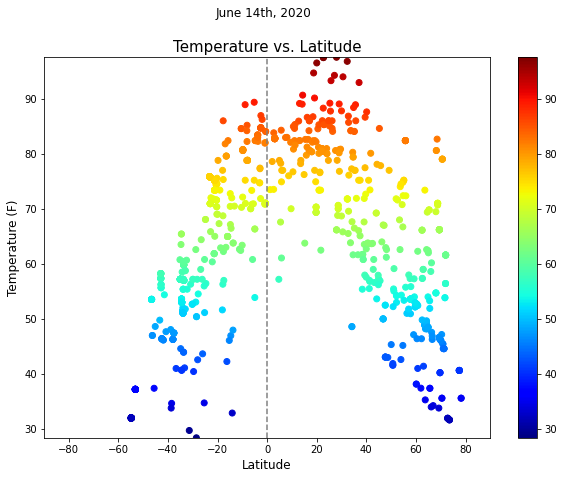

In [10]:
# make scatter plot of Temperature vs Latitude
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(
    weather_data["Latitude"],weather_data['Temperature (F)'],c=weather_data['Temperature (F)'],cmap=plt.cm.jet)
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Temperature (F)", fontsize=12)
plt.title("Temperature vs. Latitude", fontsize=15)
plt.suptitle("June 14th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.vlines(0,weather_data['Temperature (F)'].min(),weather_data['Temperature (F)'].max(),linestyles='dashed',colors='gray')
plt.ylim(weather_data['Temperature (F)'].min(),weather_data['Temperature (F)'].max())
plt.show()

## Observations
### Temperature shows a general warming trend towards the equator, but it is skewed toward the northern hemisphere. Seing as the data represents current temperatures, in the month of June, the skew may be partly due to summer conditions in the nothern hemisphere.
### The hottest temperatures are recorded around 20 degrees latitude north.
### The temperature trends show scatter on both the norther and upper hemispheres, indicating that other factors also affect temperature. 

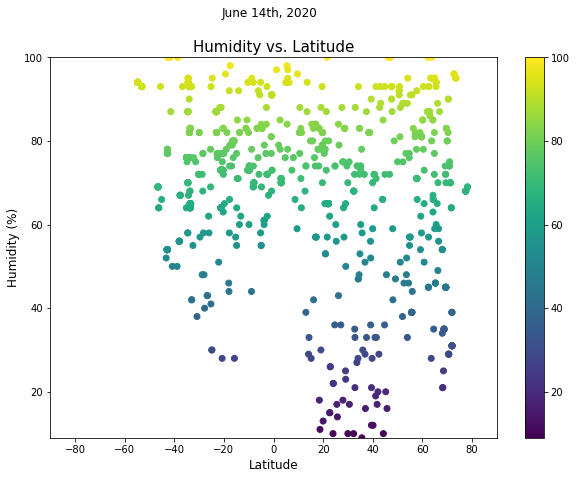

In [11]:
# make scatter plot of Humidity vs Latitude
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Humidity (%)'],c=weather_data['Humidity (%)'])
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Humidity (%)", fontsize=12)
plt.title("Humidity vs. Latitude", fontsize=15)
plt.suptitle("June 14th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.ylim(weather_data['Humidity (%)'].min(),weather_data['Humidity (%)'].max())
plt.show()

## Observations
### There is not discernible trend between latitude and current humidity.
### Places with current humidity below c. 20% are concentrated in the nothern hemisphere.

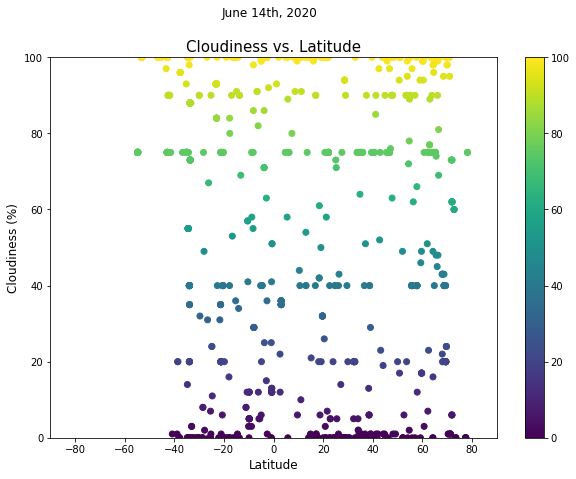

In [12]:
# make scatter plot of Cloudiness vs Latitute
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Cloudiness (%)'],c=weather_data['Cloudiness (%)'])
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Cloudiness (%)", fontsize=12)
plt.title("Cloudiness vs. Latitude", fontsize=15)
plt.suptitle("June 14th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.ylim(weather_data['Cloudiness (%)'].min(),weather_data['Cloudiness (%)'].max())
plt.show()

## Observations
### Cloudiness shows no discernible relationship with latitude for current weather conditions.

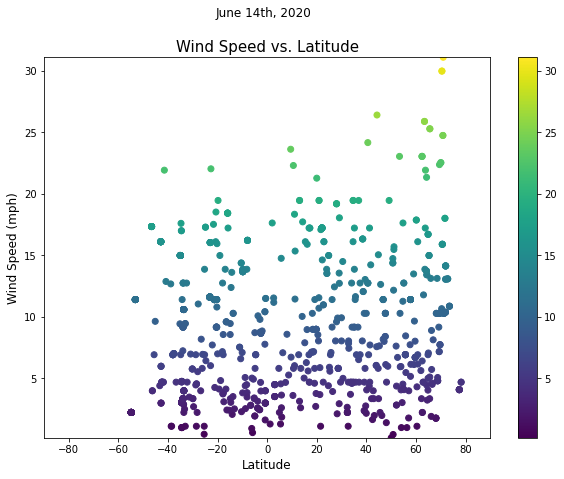

In [13]:
# make scatter plot of Wind Speed vs Latitude
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Wind Speed (mph)'],c=weather_data['Wind Speed (mph)'])
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Wind Speed (mph)", fontsize=12)
plt.title("Wind Speed vs. Latitude", fontsize=15)
plt.suptitle("June 14th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.ylim(weather_data['Wind Speed (mph)'].min(),weather_data['Wind Speed (mph)'].max())
plt.show()

## Observations
### There are no discernible trends between latitude and wind speeds  for current weather conditions.

In [14]:
# add a column to the DataFrame categorizing latitudes as northern or southern hemisphere
weather_data['Hemisphere']= ""
weather_data.loc[weather_data['Latitude']>=0,"Hemisphere"]="Northern"
weather_data.loc[weather_data['Latitude']<0,"Hemisphere"]="Southern"

In [15]:
# create separate DataFrames for each hemisphere
northern_hemisphere = weather_data.loc[(weather_data['Hemisphere']=='Northern'),:]
southern_hemisphere = weather_data.loc[(weather_data['Hemisphere']=='Southern'),:]

In [16]:
# plot the previous parameters for each group